In [1]:
import datetime
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm 
    
from IPython.display import HTML
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))    

os.chdir(r'C:\Users\User\GitHub\WebET_Analysis')
print("Current Working directory " , os.getcwd())

Current Working directory  C:\Users\User\GitHub\WebET_Analysis


# Read Data

In [2]:
data_et = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/raw/data_et.csv')
data_trial = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/raw/data_trial.csv')
data_subject = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/raw/data_subject.csv')

print(pd.DataFrame([
    [
        len(data_et), 
        len(data_et['run_id'].unique())
    ], 
    [
        len(data_trial),
        len(data_trial['run_id'].unique())
    ], 
    [
        len(data_subject), 
        len(data_subject['run_id'].unique())
    ]
], 
   columns=['length', 'run'],
   index=['data_et', 'data_trial', 'data_subject'])
)

               length  run
data_et       2700001  252
data_trial     133206  316
data_subject      316  316


# ET: Invert y_axis

In [3]:
data_et['look_top'] = 0
data_et['look_top'] = (data_et['y']<0.5).astype(int)
data_et.groupby(['look_top'])['x'].count()

look_top
0    1339893
1    1360108
Name: x, dtype: int64

In [4]:
data_et['y'] = 1- data_et['y']
data_et['y'].describe()

count    2.700001e+06
mean     5.035079e-01
std      3.122777e-01
min     -1.294222e+02
25%      3.615928e-01
50%      5.018847e-01
75%      6.455445e-01
max      3.395671e+01
Name: y, dtype: float64

In [5]:
data_et['look_top'] = 0
data_et['look_top'] = (data_et['y']<0.5).astype(int)
data_et.groupby(['look_top'])['x'].count()

look_top
0    1360108
1    1339893
Name: x, dtype: int64

# Window Size

In [6]:
def addWindowSize(data):
    grouped = data \
        .groupby(["run_id", "subject"])["window_width", "window_height"].max() \
        .reset_index()
    grouped.columns = ["run_id", "subject", "window_width_max", "window_height_max"]
    grouped['window_diagonal_max'] = np.sqrt(grouped['window_width_max']**2 + grouped['window_height_max']**2)
    if "window_width_max" in data.columns: 
        data = data.drop(columns=['window_width_max'])
    if "window_height_max" in data.columns: 
        data = data.drop(columns=['window_height_max'])
    if "window_diagonal_max" in data.columns: 
        data = data.drop(columns=['window_diagonal_max'])
    data = data.merge(grouped, on=['run_id', "subject"], how='left')
    return data

data_trial = addWindowSize(data_trial)
data_trial['window_diagonal'] =  np.sqrt(data_trial['window_width']**2 + data_trial['window_height']**2)

<ipython-input-6-1351852b2457>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped = data \


# Trial Duration

In [7]:
def checkTimeDeviation(data, column1, column2, maxTimeDiffAllowed):
    diff = data[column1] - data['trial_duration_exact']
    longtrials_runID = data.loc[diff[diff > maxTimeDiffAllowed].index, 'run_id']
    longtrials_previousrunID = pd.DataFrame(data.loc[diff[diff > maxTimeDiffAllowed].index-1, 'run_id']) \
        .rename(columns={'run_id':'previous_run_id'})
    longtrials_previousrunID.index = longtrials_runID.index
    compare_runIDs = pd.concat([longtrials_runID, longtrials_previousrunID], axis=1)

    if sum(compare_runIDs['run_id'] == compare_runIDs['previous_run_id']) > 0: 
        print(column1 + ' and ' + column2 + ' show a deviation of ' +
              '>' + str(maxTimeDiffAllowed) + 
              ' ms. Please check on the following indices: \n')
        print(compare_runIDs.loc[(compare_runIDs['run_id'] == compare_runIDs['previous_run_id']), :].index)

    else:
        print('Success! ' + column1 + ' and ' + column2 + ' do not deviate by ' +
              '>' + str(maxTimeDiffAllowed) + 'ms.')
        
def exactTrialDuration(data):
    data["t_startTrial"] = pd.concat([pd.Series([0]), data["time_elapsed"]], ignore_index=True)
    data["trial_duration_exact"] = data.loc[:, ("time_elapsed")] - data.loc[:, ("t_startTrial")]
    data.drop(len(data)-1)
    
    checkTimeDeviation(data, 'rt', 'trial_duration_exact', 50)
    checkTimeDeviation(data, 'trial_duration', 'trial_duration_exact', 50)
    
    return data

data_trial = exactTrialDuration(data_trial)

rt and trial_duration_exact show a deviation of >50 ms. Please check on the following indices: 

Int64Index([49016], dtype='int64')
Success! trial_duration and trial_duration_exact do not deviate by >50ms.


## Trial nr

In [8]:
def new_task_nr(task_nr):
    
    y = task_nr.copy()
    new_task_nr = 0

    for i in task_nr.index:
        x = task_nr[i]
        if pd.notna(x) & (x!='"'): 
            new_task_nr = x
        else: 
            y[i] = new_task_nr

    return y

def add_new_task_nr(data):
    data.loc[data['trial_index']==0, 'task_nr'] = 0 
    data['task_nr_new'] = new_task_nr(data['task_nr'])
    data['task_nr_new'] = data['task_nr_new'].astype(int)
    return data

data_trial = add_new_task_nr(data_trial)

## Trial type new
Most of these subjects reloaded when the eye-tracking initialized as well as during the first calibration

In [9]:
def add_trial_type_new(data):
    
    data['trial_type_new'] = 0
    
    data.loc[
        (data['run_id']<144) & (data['chinFirst']==0), 
        'trial_type_new'
    ] = pd.cut(
        data.loc[
            (data['run_id']<144) & (data['chinFirst']==0), 
            'trial_index'], 
        np.array([
            0,
            1.5, # start_page
            2.5, # prolific_id
            4.5, # pre_et_init
            5.5, # et_init
            11, # et_adjustment
            17.5, # calibration_1_briefing
            18.5, # first_cal
            97, # calibration_1
            134, # fixation_1
            221, # calibration_2
            259, # fixation_2
            514, # choice
            520 # end
        ]),
        labels=np.array([
            'start_page',
            'prolific_id',
            'pre_et_init',
            'et_init',
            'et_adjustment',
            'calibration_1_briefing',
            'first_cal', 
            'calibration_1',
            'fixation_1',
            'calibration_2',
            'fixation_2',
            'choice',
            'end'
        ]),
        include_lowest=True, 
    )

    data.loc[
        (data['run_id']<144) & (data['chinFirst']==1), 
        'trial_type_new'
    ] = pd.cut(
        data.loc[
            (data['run_id']<144) & (data['chinFirst']==1), 
            'trial_index'], 
        np.array([
            0, # 
            1.5, # start_page
            2.5, # prolific_id
            4.5, # pre_et_init
            5.5, # et_init
            11, # et_adjustment
            17.5, # calibration_1_briefing
            18.5, # first_cal
            97, # calibration_1
            134, # fixation_1
            387, # choice
            473, # calibration_2
            513, # fixation_2
            520 # end
        ]),
        labels=np.array([
            'start_page',
            'prolific_id',
            'pre_et_init',
            'et_init',
            'et_adjustment',
            'calibration_1_briefing',
            'first_cal', 
            'calibration_1',
            'fixation_1',
            'choice',        
            'calibration_2',
            'fixation_2',
            'end'
        ]),
        include_lowest=True, 
    )

    data.loc[
        (data['run_id']>143) & (data['chinFirst']==0), 
        'trial_type_new'
    ] = pd.cut(
        data.loc[
            (data['run_id']>143) & (data['chinFirst']==0), 
            'trial_index'], 
        np.array([
            0,
            1.5, # start_page
            2.5, # prolific_id
            4.5, # pre_et_init
            5.5, # et_init
            11, # et_adjustment
            17.5, # calibration_1_briefing
            97, # calibration_1
            143, # fixation_1
            231, # calibration_2
            277, # fixation_2
            532, # choice
            540 # end
        ]),
        labels=np.array([
            'start_page',
            'prolific_id',
            'pre_et_init',
            'et_init',
            'et_adjustment',
            'calibration_1_briefing',
            'calibration_1',
            'fixation_1',
            'calibration_2',
            'fixation_2',
            'choice',
            'end'
        ]),
        include_lowest=True, 
    )

    data.loc[
        (data['run_id']>143) & (data['chinFirst']==1), 
        'trial_type_new'
    ] = pd.cut(
        data.loc[
            (data['run_id']>143) & (data['chinFirst']==1), 
            'trial_index'], 
        np.array([
            0, # 
            1.5, # start_page
            2.5, # prolific_id
            4.5, # pre_et_init
            5.5, # et_init
            11, # et_adjustment
            17.5, # calibration_1_briefing
            97, # calibration_1
            143, # fixation_1
            397, # choice
            483, # calibration_2
            532, # fixation_2
            540 # end
        ]),
        labels=np.array([
            'start_page',
            'prolific_id',
            'pre_et_init',
            'et_init',
            'et_adjustment',
            'calibration_1_briefing',
            'calibration_1',
            'fixation_1',
            'choice',        
            'calibration_2',
            'fixation_2',
            'end'
        ]),
        include_lowest=True, 
    )
    
    return data

data_trial = add_trial_type_new(data_trial)

data_trial.loc[
    (data_trial['run_id']>143) & (data_trial['chinFirst']==1), 
    ['trial_index', 'task_nr_new', 'trial_type_new', 'trial_type', 'stimulus', 'task_nr']
].iloc[530:540]

,trial_index,task_nr_new,trial_type_new,trial_type,stimulus,task_nr
5258,530,3,fixation_2,html-keyboard-response,"""",NaN
5259,531,3,fixation_2,html-keyboard-response,"""",NaN
5260,532,3,fixation_2,fullscreen,"""",NaN
5261,533,3,end,html-keyboard-response,You completed the study to 90% Press Space to ...,NaN
5262,534,3,end,survey-html-form,"""",NaN
5263,535,3,end,survey-html-form,"""",NaN
5264,536,3,end,survey-html-form,"""",NaN
5265,537,3,end,survey-html-form,"""",NaN
5813,0,0,start_page,html-keyboard-response,"""",0.0
5814,1,0,start_page,html-button-response,"Welcome, dear participant! Thank you for your ...",NaN


In [10]:
order_trial_types = pd.DataFrame(
    {'trial_type_new': [
                'start_page',
                'prolific_id',
                'pre_et_init',
                'et_init',
                'et_adjustment',
                'calibration_1_briefing',
                'calibration_1',
                'fixation_1',     
                'calibration_2',
                'fixation_2',
                'choice',   
                'end'
            ],
     'trial_type_nr': np.arange(12)
    }
)

if 'trial_type_nr' in data_trial.columns: 
    data_trial = data_trial.drop(columns='trial_type_nr')
    
data_trial = data_trial \
    .merge(order_trial_types, on='trial_type_new', how='left') 

# Identify fixation task

In [11]:
data_trial['fixTask'] = 0

data_trial.loc[
    (data_trial['trial_type']=='eyetracking-fix-object') & 
    (data_trial['trial_duration']==5000),
    'fixTask'
] = 1
data_trial['fixTask'].unique()

array([0, 1], dtype=int64)

# withinTaskIndex

In [12]:
def withinTaskIndex(data): 
    allTrialIndices = []
    for subject in tqdm(data["run_id"].unique()):
        df_subj = data.loc[data['run_id']==subject, :]

        for trial_type in df_subj['trial_type'].unique():
            df_trial = df_subj.loc[df_subj['trial_type']==trial_type, :]
            
            for task_nr in df_trial["task_nr"].unique():
                df_task = df_trial.loc[df_trial['task_nr']==task_nr, :]
                        
                for fixTask in df_task['fixTask'].unique():
                    df_fixTask = df_task.loc[
                        df_task['fixTask']==fixTask,  
                        ['run_id', 'trial_index']] \
                    .drop_duplicates() \
                    .reset_index(drop=True)
        
                    df_fixTask['withinTaskIndex'] = df_fixTask.index + 1
                    allTrialIndices.append(df_fixTask)
    allTrialIndices = pd.concat(allTrialIndices).reset_index(drop=True)
    return allTrialIndices

def addWithinTaskIndex(data):
    newIndices = withinTaskIndex(data)
    if 'withinTaskIndex' in data.columns: data = data.drop(columns=['withinTaskIndex'])
    data = data.merge(newIndices, on = ['run_id', 'trial_index'], how = 'left')
    return data

data_trial = addWithinTaskIndex(data_trial)

100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:11<00:00, 27.01it/s]


In [13]:
data_trial.loc[
    (data_trial['run_id']==103) &
    (data_trial['trial_type']=='eyetracking-choice'), 
    ['run_id', 'trial_index', 'task_nr', 
     'trial_type',
     'fixTask', 'withinTaskIndex']
]

,run_id,trial_index,task_nr,trial_type,fixTask,withinTaskIndex
789,103,270,3.0,eyetracking-choice,0,1.0
792,103,273,3.0,eyetracking-choice,0,2.0
795,103,276,3.0,eyetracking-choice,0,3.0
798,103,279,3.0,eyetracking-choice,0,4.0
801,103,282,3.0,eyetracking-choice,0,5.0
...,...,...,...,...,...,...
1015,103,496,3.0,eyetracking-choice,0,76.0
1018,103,499,3.0,eyetracking-choice,0,77.0
1021,103,502,3.0,eyetracking-choice,0,78.0
1024,103,505,3.0,eyetracking-choice,0,79.0


# fps

## trial_level

In [14]:
def merge_count_by_index(data, large_data, varName):
    if varName + '_count' in data.columns: data = data.drop(columns=[varName + '_count'])
    grouped = large_data.groupby(["run_id", "trial_index"])[varName].count() \
        .reset_index() \
        .rename(columns={varName: varName + '_count'})
    data = data.merge(grouped, on=["run_id", "trial_index"], how='left')
    return(data)

data_trial = merge_count_by_index(data_trial, data_et, 'x')

data_trial['fps'] = 1000 * data_trial['x_count'] / data_trial['trial_duration_exact']
data_trial['fps'].describe()

count    66224.000000
mean        14.282706
std          6.851520
min          0.002372
25%         10.168274
50%         14.184397
75%         18.400254
max         47.811837
Name: fps, dtype: float64

In [15]:
def spaghettiPlot(data, xVar, yVar, highlightedSubject):
    plt.style.use('seaborn-darkgrid')
    fig, ax = plt.subplots(figsize=(15, 10))

    # Draw Plots
    for subject in data["run_id"].unique():
        ax.plot(data.loc[data['run_id']==subject, xVar], 
                data.loc[data['run_id']==subject, yVar], 
                marker='', color='grey', linewidth=1, alpha=0.4)

    # Highlight Subject 
    ax.plot(data.loc[data['run_id']==highlightedSubject, xVar], 
            data.loc[data['run_id']==highlightedSubject, yVar], 
            marker='', color='orange', linewidth=4, alpha=0.7)

    # Let's annotate the plot
    for subject in data["run_id"].unique():
        if subject != highlightedSubject:
            ax.text(data.loc[data['run_id']==subject, xVar].max()+1, 
                    data.loc[data['run_id']==subject, yVar].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='grey')

        else:
            ax.text(data.loc[data['run_id']==subject, xVar].max()+1, 
                    data.loc[data['run_id']==subject, yVar].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='orange')
    return plt

In [16]:
spaghettiPlot(
    data_trial.loc[(data_trial['chinFirst']==0) & pd.notna(data_trial['fps']), :], 
    'trial_index', 'fps', 103
)
plt.title('chinFirst == 0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('trial_index')
plt.ylabel('fps')
plt.vlines(18, 45, 50, colors='add_k', linestyles='solid')
plt.text(18+1, 50, s='Calibration')
plt.vlines(105, 45, 50, colors='add_k', linestyles='solid')
plt.text(105+1, 50, s='fix Task')
plt.vlines(143, 45, 50, colors='add_k', linestyles='solid')
plt.text(143+1, 50, s='Calibration')
plt.vlines(230, 45, 50, colors='add_k', linestyles='solid')
plt.text(230+1, 50, s='fix Task')
plt.vlines(269, 45, 50, colors='add_k', linestyles='solid')
plt.text(269+1, 50, s='choice Task')
plt.show()

In [17]:
spaghettiPlot(
    data_trial.loc[(data_trial['chinFirst']==1) & pd.notna(data_trial['fps']), :], 
    'trial_index', 'fps', 91
)
plt.title('chinFirst == 1', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('trial_index')
plt.ylabel('fps')
plt.vlines(18, 45, 50, colors='add_k', linestyles='solid')
plt.text(18+1, 50, s='Calibration')
plt.vlines(105, 45, 50, colors='add_k', linestyles='solid')
plt.text(105+1, 50, s='fix Task')
plt.vlines(144, 45, 50, colors='add_k', linestyles='solid')
plt.text(144+1, 50, s='choice Task')
plt.vlines(394, 45, 50, colors='add_k', linestyles='solid')
plt.text(394+1, 50, s='Calibration')
plt.vlines(482, 45, 50, colors='add_k', linestyles='solid')
plt.text(482+1, 50, s='fix Task')
plt.show()

## subject-level

(array([13.,  7., 18., 12., 25., 28., 41., 31., 25., 28., 11.,  7.,  1.,
         4.,  1.]),
 array([ 0.10596656,  2.26687086,  4.42777517,  6.58867947,  8.74958378,
        10.91048808, 13.07139239, 15.2322967 , 17.393201  , 19.55410531,
        21.71500961, 23.87591392, 26.03681822, 28.19772253, 30.35862683,
        32.51953114]),
 <BarContainer object of 15 artists>)

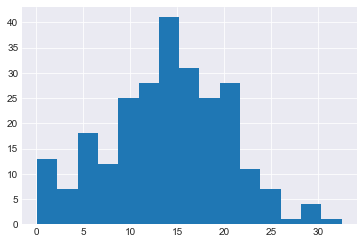

In [18]:
def merge_mean_by_subject(data, large_data, varName):
    if varName in data.columns: data = data.drop(columns=[varName])
    grouped = large_data.groupby(['run_id'])[varName].mean() \
        .reset_index()        
    data = data.merge(grouped, on=['run_id'], how='left')
    return data

data_subject = merge_mean_by_subject(data_subject, data_trial, 'fps')
plt.hist(data_subject['fps'], bins=15)

# Position index (for fixation tasks)

In [19]:
def addPositionIndex(data):
    data['positionIndex'] = 0

    x_pos = [0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.35, 0.65, 0.35, 0.65]
    y_pos = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8, 0.35, 0.35, 0.65, 0.65]

    for i in range(0, len(x_pos)):
        data.loc[(data['x_pos']==x_pos[i]) & (data['y_pos']==y_pos[i]), 'positionIndex']=i
    return data

data_trial = addPositionIndex(data_trial)

data_trial.loc[
    (data_trial['trial_type']=='eyetracking-calibration'), ['x_pos', 'y_pos', 'positionIndex']] \
    .drop_duplicates() \
    .sort_values(by='positionIndex')

,x_pos,y_pos,positionIndex
42,0.20,0.20,0
28,0.50,0.20,1
18,0.80,0.20,2
22,0.20,0.50,3
38,0.50,0.50,4
34,0.80,0.50,5
40,0.20,0.80,6
32,0.50,0.80,7
30,0.80,0.80,8
26,0.35,0.35,9


# data_subject

## Trials

In [20]:
data_subject = data_subject \
    .merge(
        data_trial.groupby(['run_id'], as_index=False)['trial_index'].max(),
        on=['run_id'], 
        how='left') \
    .rename(columns={'trial_index': 'max_trial'})

data_subject.loc[
    :,
    ['run_id', 'max_trial']
]

,run_id,max_trial
0,1,518
1,103,518
2,105,0
3,106,2
4,108,4
...,...,...
311,94,519
312,96,519
313,97,519
314,98,519


## Glasses binary

In [21]:
data_subject['glasses_binary'] = data_subject['sight'] \
    .replace({'contactLenses': 0, 
             'glasses': 1,
             'notCorrected': 0,
             'perfectSight': 0}
           )
print(data_subject['glasses_binary'].unique())

for col in ['glasses', 'sight', 'glasses_binary']:
    print(pd.crosstab(index=data_subject[col], columns="count"))
    print('\n')

[ 1.  0. nan]
col_0         count
glasses            
longSight        27
noCorrection    112
progressive      19
shortSight       85


col_0          count
sight               
contactLenses     27
glasses           97
notCorrected      12
perfectSight     107


col_0           count
glasses_binary       
0.0               146
1.0                97




## Var recorded_at

In [22]:
def add_recorded_date(data, data_trial):
    output = []

    for subject in tqdm(data_trial['run_id'].unique()):
        thisSubject = data_trial.loc[data_trial['run_id'] == subject] \
            .reset_index(drop=True)
        date_time_obj = datetime.datetime.strptime(
            thisSubject.loc[0, 'recorded_at'], '%Y-%m-%d %H:%M:%S')

        output.append([thisSubject.loc[0, 'run_id'], date_time_obj.date()])

    output = pd.DataFrame(output, columns=['run_id', 'recorded_date'])

    if 'recorded_date' in data.columns: data = data.drop(columns=['recorded_date'])
    data = data.merge(output, on='run_id', how='left')
    return data

data_subject = add_recorded_date(data_subject, data_trial)
data_subject['recorded_date'].describe()

100%|███████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 649.71it/s]


count            316
unique             6
top       2021-02-13
freq             111
Name: recorded_date, dtype: object

## Degree

In [23]:
data_subject['degree'] = data_subject['degree'] \
    .replace(
        ['-3.0', '0', '1.25', '1.5', '2', '4.25'], 
        np.nan
)

data_subject['degree'] = data_subject['degree'].replace({
    'Middle School': 'middle',
    'middleSchool': 'middle',
    'High School': 'high',
    'high school': 'high',
    'highSchool': 'high',
    'Associates Degree': 'high',
    'Associate ': 'high',

    'College / Undergraduate / Bachelor': 'college',
    'Bachelor': 'college',    
    
    'masters degree': 'grad',
    'graduate': 'grad',
    'Grad': 'grad',
    'Graduate / PhD / Master': 'grad',
    'masters degree': 'grad',
})
data_subject['degree'] = data_subject['degree'].astype('category')
data_subject['degree'].cat.reorder_categories(['middle', 'high', 'college', 'grad'], inplace=True)
data_subject['degree'].unique()

['high', 'college', NaN, 'grad', 'middle']
Categories (4, object): ['high', 'college', 'grad', 'middle']

In [24]:
data_subject['webcam_fps'] = np.round(data_subject['webcam_fps'])

## Emloyment

In [25]:
data_subject['Employment Status'].unique()

array([nan, 'Other', 'Full-Time', 'CONSENT REVOKED', 'Part-Time',
       "Not in paid work (e.g. homemaker', 'retired or disabled)",
       'DATA EXPIRED', 'Unemployed (and job seeking)',
       'Due to start a new job within the next month'], dtype=object)

In [26]:
data_subject['employment_status'] = data_subject['Employment Status'].replace({
    """Not in paid work (e.g. homemaker', 'retired or disabled)""": 'not_in_paid_work',
    'DATA EXPIRED': 'Other',
    'Unemployed (and job seeking)': 'not_in_paid_work',
    'Due to start a new job within the next month': 'Other'
})
data_subject['Employment Status'].unique()

array([nan, 'Other', 'Full-Time', 'CONSENT REVOKED', 'Part-Time',
       "Not in paid work (e.g. homemaker', 'retired or disabled)",
       'DATA EXPIRED', 'Unemployed (and job seeking)',
       'Due to start a new job within the next month'], dtype=object)

In [27]:
data_subject['fullTime_binary'] = data_subject['Employment Status'].replace({
    'Other': 0,
    'Full-Time': 1,
    'Part-Time': 0,
    "Not in paid work (e.g. homemaker', 'retired or disabled)": 0,
    'Unemployed (and job seeking)': 0, 
    'DATA EXPIRED': 0
})

# Export data

In [28]:
data_et.to_csv("data_jupyter/added_var/data_et.csv", index=False, header=True)
data_trial.to_csv("data_jupyter/added_var/data_trial.csv", index=False, header=True)
data_subject.to_csv("data_jupyter/added_var/data_subject.csv", index=False, header=True)

# Feedback

In [29]:
print('Success! Script ran through')

Success! Script ran through
